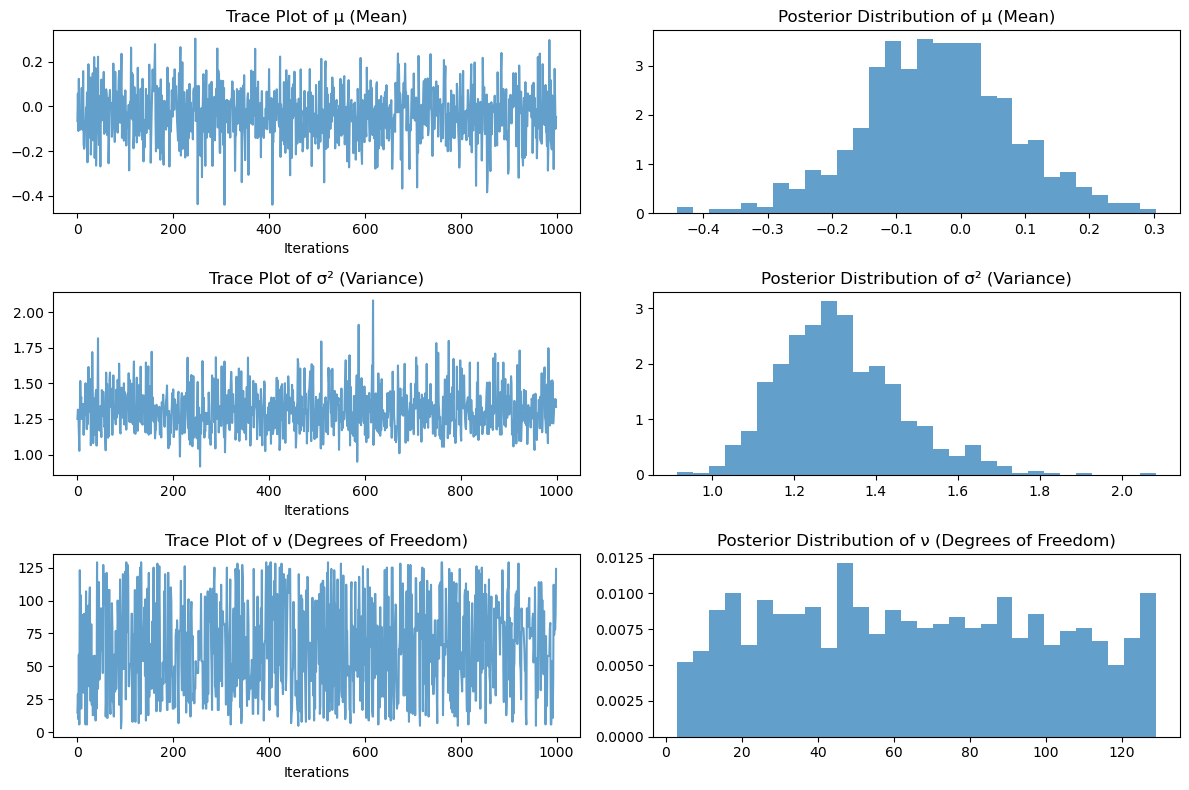

In [5]:
#Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def metropolis_gibbs_sampling(iterations=1500, burn_in=500):
    np.random.seed(150)
    n = 130
    observations = np.random.standard_t(df=5, size=n)
    
    mu_curr = np.median(observations) 
    sigma_sq_curr = np.var(observations) * 1.2 
    nu_curr = 10  
    
    trace_samples = np.zeros((iterations, 3))
    
    for step in range(iterations):
        nu_candidate = np.random.choice(range(2, 130))  
        mu_candidate = np.random.normal(mu_curr, np.sqrt(sigma_sq_curr / n))
        shape = (nu_candidate + n + 2) / 2
        scale = (np.sum((observations - mu_candidate) ** 2) + nu_candidate) / 2
        sigma_sq_candidate = 1 / np.random.gamma(shape, 1 / scale)
        
        log_ratio = (
            stats.t.logpdf(observations, df=nu_candidate, loc=mu_candidate, scale=np.sqrt(sigma_sq_candidate)).sum()
            - stats.t.logpdf(observations, df=nu_curr, loc=mu_curr, scale=np.sqrt(sigma_sq_curr)).sum()
        )  
        
        if np.log(np.random.rand()) < log_ratio:
            nu_curr = nu_candidate
        
        trace_samples[step] = [mu_candidate, sigma_sq_candidate, nu_curr]
    
    return trace_samples[burn_in:]

# Run the sampler
samples = metropolis_gibbs_sampling()

# Visualization: Trace Plots & Histograms
def plot_gibbs_results(samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    labels = ["μ (Mean)", "σ² (Variance)", "ν (Degrees of Freedom)"]
    
    for i in range(3):
        # Trace plot
        axes[i, 0].plot(samples[:, i], alpha=0.7)
        axes[i, 0].set_title(f"Trace Plot of {labels[i]}")
        axes[i, 0].set_xlabel("Iterations")
        
        # Histogram
        axes[i, 1].hist(samples[:, i], bins=30, density=True, alpha=0.7)
        axes[i, 1].set_title(f"Posterior Distribution of {labels[i]}")
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_gibbs_results(samples)


In [ ]:
##Q2
import pymc as pm
import arviz as az
import numpy as np
from scipy import stats

np.random.seed(123)
sample_sizes = [50, 200, 800, 1600]  # Adjusted sample sizes
mu_true = 1.0  # Changed true mean
sigma_true = 1.5  # Changed true standard deviation
nu_true = 30  # Changed true degrees of freedom

bayesian_results = {}

for n in sample_sizes:
    # Generate t-distributed data
    x = mu_true + sigma_true * stats.t.rvs(df=nu_true, size=n)

    with pm.Model() as model:
        # Priors
        mu = pm.Normal("mu", mu=0, sigma=2)  # Adjusted prior
        sigma = pm.HalfNormal("sigma", sigma=2)  # Adjusted prior
        nu = pm.DiscreteUniform("nu", lower=2, upper=100)  # Adjusted range

        # Likelihood
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Sampling
        trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, return_inferencedata=True)

    bayesian_results[n] = trace

for n in sample_sizes:
    print(f"Sample size: {n}")
    print(az.summary(bayesian_results[n], var_names=["nu"]))


# Q3: Posterior Predictive Distribution Explanation

"""
## Bayesian Interpretation of the Posterior Predictive Distribution

In Bayesian analysis, incorporating uncertainty in model parameters through the posterior predictive distribution enhances the robustness of inference. This is especially beneficial for small datasets and hierarchical models.
### Derivation
To marginalize out the latent precision parameter $\tau_i$, we start with:

$$
p(y_i) = \int_0^{\infty} p(y_i | \tau_i) p(\tau_i) d\tau_i$$

where:
- $p(y_i | \tau_i)$ follows a normal likelihood,
- $p(\tau_i)$ follows a gamma distribution.

Using the gamma distribution identity:

$$
\int_0^{\infty} \tau_i^{a-1} e^{-b \tau_i} d \tau_i = \frac{\Gamma(a)}{b^a}
$$

we rewrite:

$$
\frac{1}{\sqrt{2\pi}} \frac{( \frac{\nu}{2} )^{\nu/2}}{\Gamma(\frac{\nu}{2})} \frac{\Gamma(\frac{\nu+1}{2})}{( \frac{y_i^2+\nu}{2} )^{(\nu+1)/2}}
$$

which simplifies to:

$$
p(y_i) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu \pi} \Gamma(\frac{\nu}{2})} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$

This is exactly the **Student’s t-distribution** with $\nu$ degrees of freedom.

### Interpretation

1. **Heavy-Tailed Nature**
   - The Student-T distribution is more **robust** to outliers than a normal distribution.
   - Smaller values of \( \nu \) correspond to **heavier tails**, allowing for more flexible modeling.
2. **Bayesian Hierarchical Models**
   - The t-distribution arises naturally when integrating over latent variance parameters in hierarchical models.
3. **Asymptotic Normality**
   - the Student-T distribution converges to the **normal distribution**
4. **Real-World Applications**
   - **Finance**: Financial Risk Modeling (Stock Returns & Volatility)
   - **Medical Statistics**: Patient response data may have variability beyond a normal assumption.
   - **Robust Regression**: t-distribution handles non-Gaussian residuals better.

### Conclusion
In Bayesian analysis, the Student’s t-distribution naturally arises when accounting for uncertainty in variance. This offers a statistically rigorous and practically reliable approach to managing real-world data prone to outliers.
"""


